In [276]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os,sys,time
from glob import glob
from scipy.optimize import fmin
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy import interpolate

In [277]:
def light_curve(lc_dir,norm=1,D_all=False,look=False):
    data = np.genfromtxt(lc_dir,names="time,flux")
    Time = data['time']
    flux = data['flux']

#   norm ot 0 
    if norm == 0:
        min_flux = np.min(np.append(flux[int(len(flux)*0.05):int(len(flux)*0.4)],\
                                    flux[int(len(flux)*0.6):-int(len(flux)*0.05)]))
        norm_flux = (flux - np.median(flux))/(np.median(flux) - min_flux)
#   norm to 1
    if norm == 1:
#         norm_flux = flux/np.median(flux)
        norm_flux = flux/1.17796311395667e+28
#         print(np.median(flux))
#   norm to std
    if norm == 2:
        norm_flux = (flux - np.median(flux))/np.std(flux)
#   norm to max - min
    if norm == 3:
        norm_flux = (flux - np.median(flux))/(np.max(flux) - np.min(flux))

    if look == True:
        plt.figure(figsize=(10,5))
        plt.plot(Time,norm_flux,'c')
        plt.plot(Time,norm_flux,'r.')
        plt.xlabel('time');plt.ylabel('flux')
#         plt.ylim(0.99,1.01)
#         plt.xlim(-37,-36.25)
        plt.show()
    
    return Time,norm_flux

In [305]:
def sec_poly(x,a,b,c):
    y = a*x**2+b*x+c
    return y

def sixth_poly(x,a,b,c,d,e,f,g):
    y = a*(x**6) + b*(x**5) + c*(x**4) + d*(x**3) + e*(x**2) + f*x + g
    return y

def fifth_poly(x,b,c,d,e,f,g):
    y = b*(x**5) + c*(x**4) + d*(x**3) + e*(x**2) + f*x + g
    return y

def fit_spot(lc_dir,limy=(0,0),look=False):
    sp_t, sp_f = light_curve(lc_dir)
#     noecli = '/Users/laote/sdsu/Research/binary/ELC/ELC_rt/ELC_nospot/modelU_140_90.0000_250.0000_noecli.linear'
#     noecl_t, noecl_f = light_curve(noecli)
#     return sp_t,sp_f-noecl_f
    step = 30
    
    w = (sp_t < -37.5)
    x = sp_t[w]; y = sp_f[w]
    x = [x[i] for i in range(0,len(x),step)]
    y = [y[i] for i in range(0,len(y),step)]
    x.append(sp_t[-1])
    y.append(sp_f[-1])
    func = interpolate.interp1d(x,y)
    testy1 = func(sp_t[w])
    
    w1 = ((sp_t <= -35.5) & (sp_t >= -37.5))
    w = ((sp_t <= -35.5) & (sp_t >= -36.4)) | ((sp_t <= -36.8) & (sp_t >= -37.5))
    x = sp_t[w]; y = sp_f[w]
    popt, pcov = curve_fit(sec_poly, x, y)
    testy2 = sec_poly(sp_t[w1],popt[0],popt[1],popt[2])
#     plt.figure(figsize=(20,10))
#     plt.plot(sp_t[w1],sp_f[w1],'r.')
#     plt.plot(sp_t[w1],testy2,'c-')
#     plt.show()
    
    
    w = (sp_t > -35.5)
    x = sp_t[w]; y = sp_f[w]
    x = [x[i] for i in range(0,len(x),step)]
    y = [y[i] for i in range(0,len(y),step)]
    x.append(sp_t[-1])
    y.append(sp_f[-1])
    func = interpolate.interp1d(x,y)
    testy3 = func(sp_t[w])
    
    testy = np.concatenate([testy1, testy2])
    testy = np.concatenate([testy, testy3])
    
    if look == True:
        plt.figure(figsize=(20,10))
        plt.plot(sp_t,sp_f-testy,'r.-')
        if limy[0] != 0:
            plt.ylim(limy[0],limy[1])
        plt.show()
    return sp_t,sp_f-testy

In [306]:
basedir = '/Users/laote/sdsu/Research/binary/ELC/ELC_rt'
baseMUdir = basedir + '/ELC_modelU'
basenpdir = basedir + '/ELC_nospot'


nsp_t, nsp_f = light_curve(basenpdir + '/modelU_14070.linear')
modelU = glob(baseMUdir + '/*.linear')
modelU = sorted(modelU, key=lambda name: int(name[70:-21] + name[-15:-12]))
temp = [];latit = [];longi = []
for i in range(len(modelU)):
    temp.append(modelU[i][63:69])
    latit.append(modelU[i][70:-16])
    longi.append(modelU[i][-15:-7])
temp = np.array(temp).astype(float)
latit = np.array(latit).astype(float)
longi = np.array(longi).astype(float)

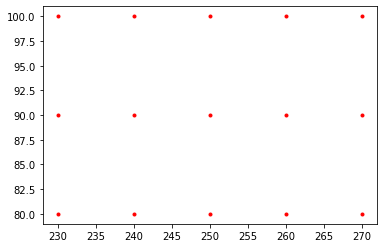

In [307]:
plt.plot(longi,latit,'r.')

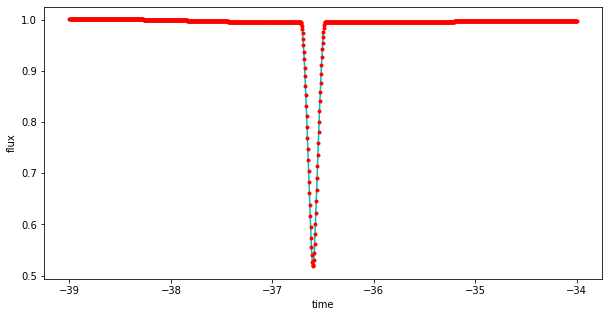

(array([-39.        , -38.99604307, -38.99208614, ..., -34.00635434,
        -34.00239741, -33.99844048]),
 array([1.00030277, 1.0002998 , 1.00029928, ..., 0.99678603, 0.99678568,
        0.996779  ]))

In [308]:
light_curve(basedir + '/ELC_modelU/modelU_0.7000_90.0000_250.0000.linear',look=True)

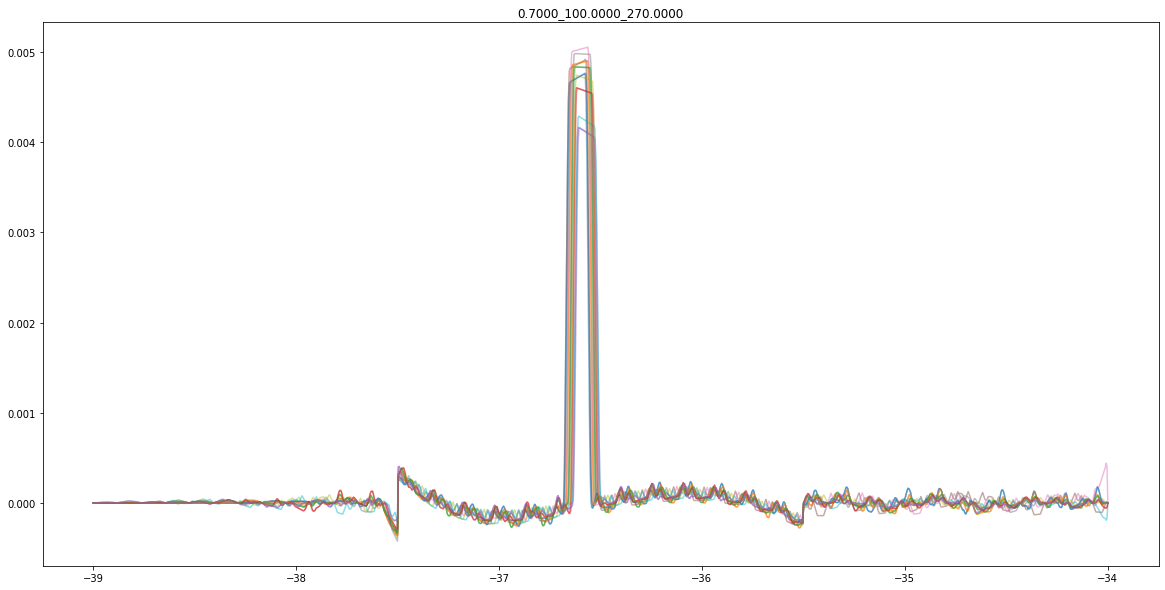

In [309]:
norm_npt, norm_npf = fit_spot(basenpdir + '/modelU_14070.linear')
peak = []
plt.figure(figsize=(20,10))
for i in range(len(modelU)):
#     if np.float(modelU[i][-15:-7])>230:
    a,b = fit_spot(modelU[i])
    max_b = np.round(np.max(b-norm_npf),5)
    peak.append(max_b)
    plt.title(modelU[i][63:-7])
    plt.plot(a,b-norm_npf,'-',alpha=0.5)#,label="%s(%s)"%(modelU[i][63:-7],max_b)
# plt.xlim(-38,-35)
# plt.ylim(-0.0001,0.000001)
    
# plt.legend()
plt.show()

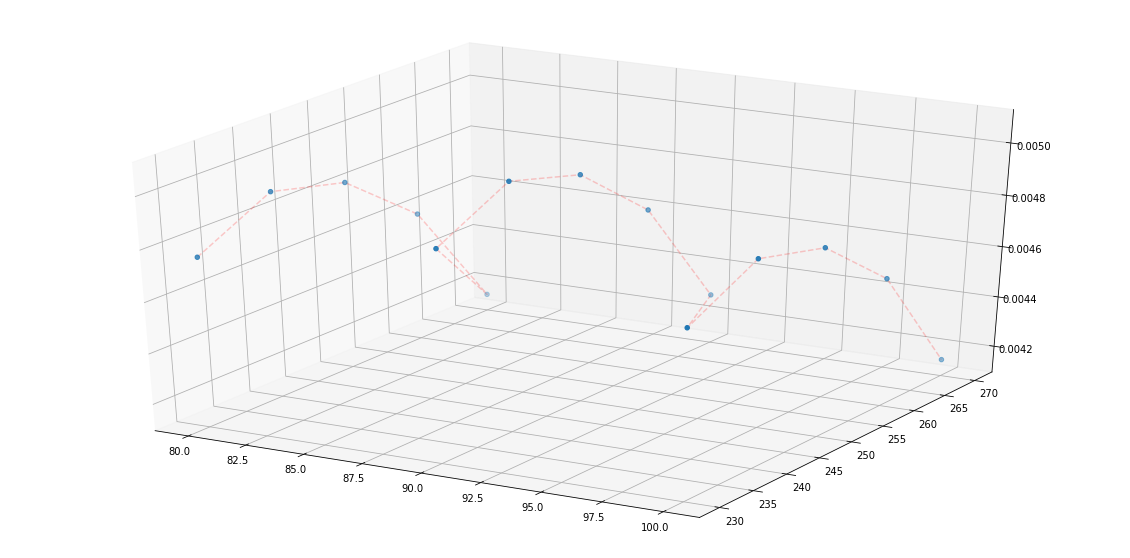

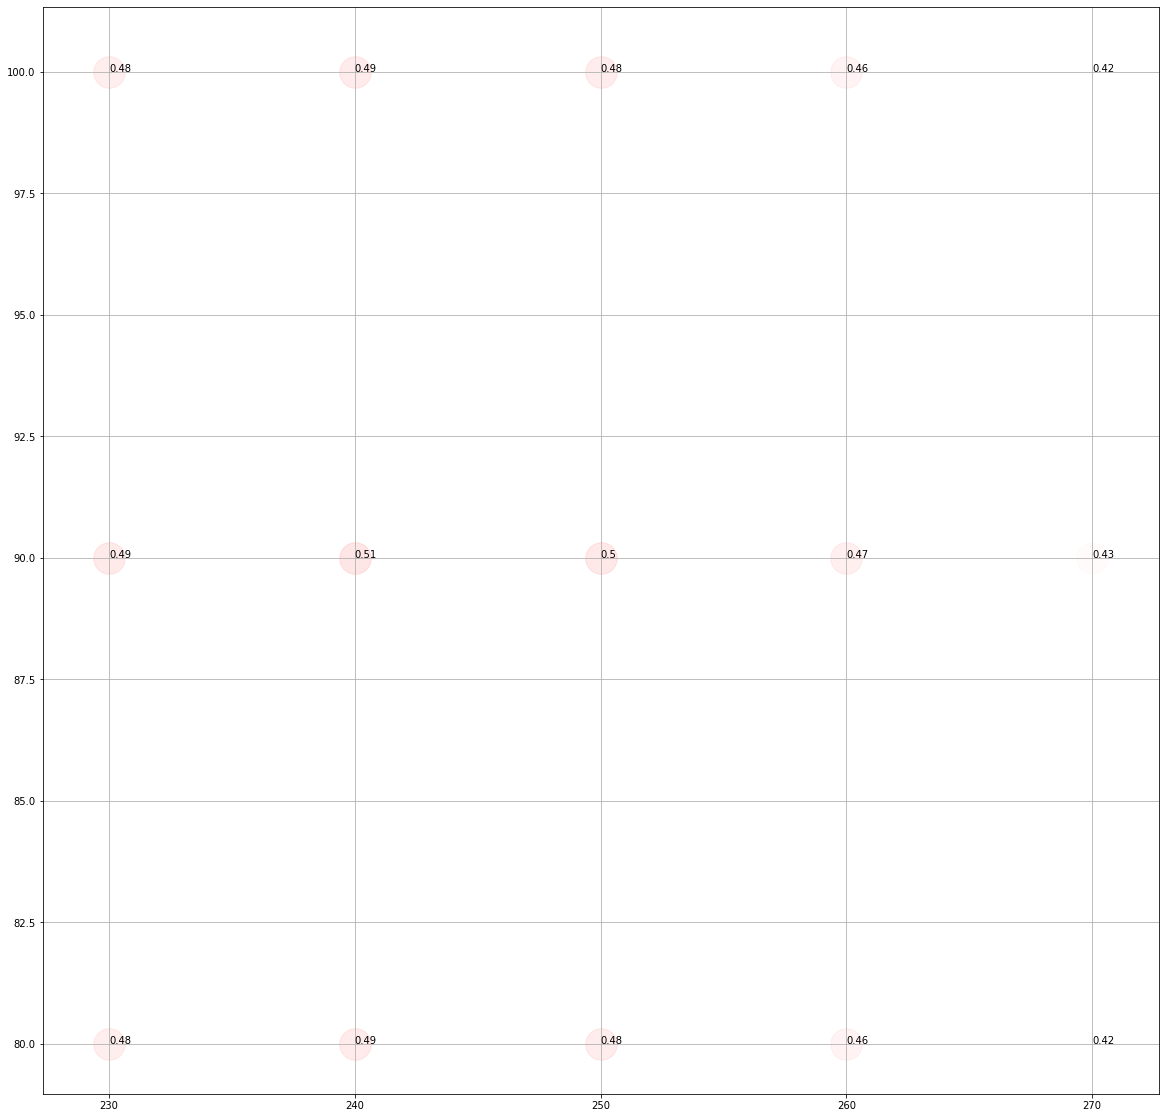

In [310]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(latit, longi, peak)
ax.plot(latit, longi, peak,'r--',alpha=0.2)

plt.figure(figsize=(20,20))
for i in range(len(peak)):
    bright = (peak[i]-np.min(peak))/(np.min(peak)+np.max(peak))
    if bright < 0:
        bright = 0
    plt.scatter(longi[i], latit[i],s=1000,color='r', alpha = bright)
    plt.annotate('%s'%(round(peak[i]*100,2)), xy=(longi[i], latit[i]))
plt.grid()

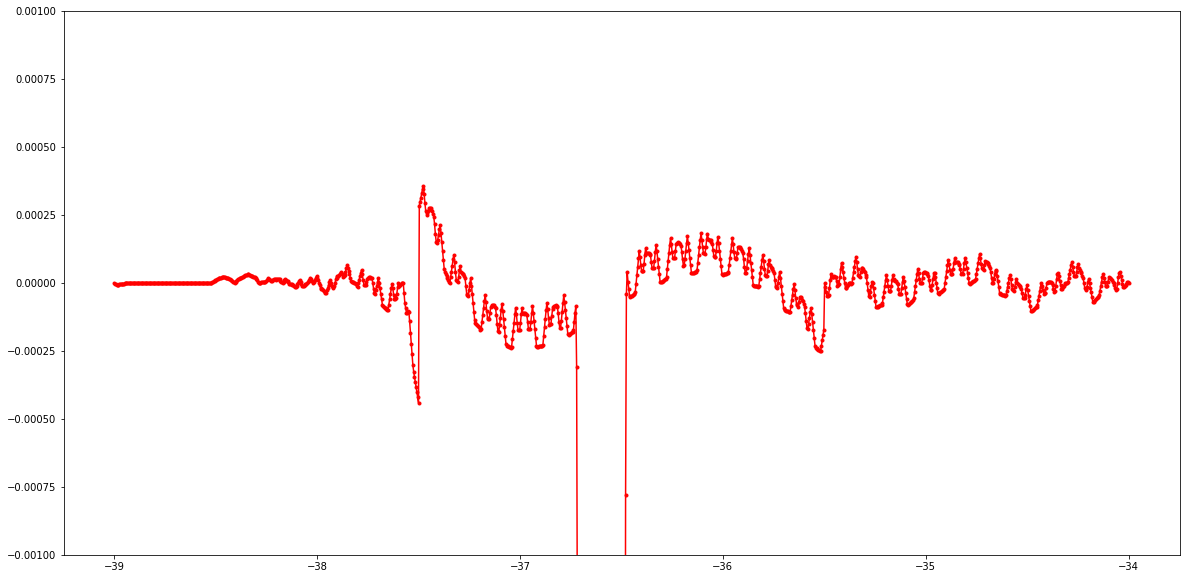

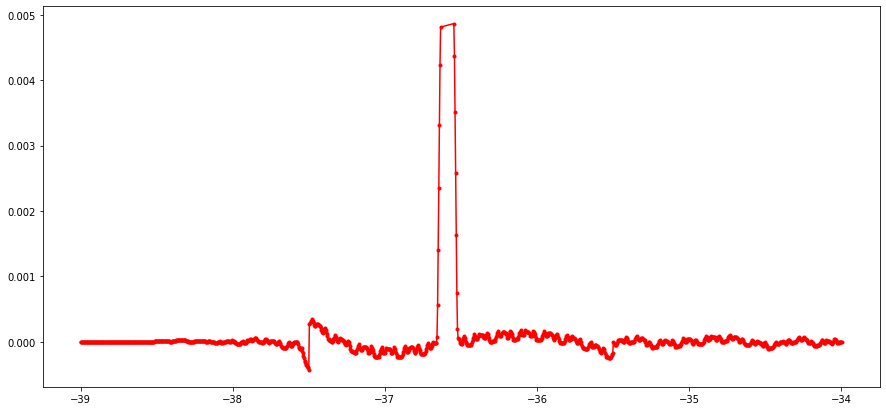

In [398]:
basepdir = basedir + '/ELC_modelU/modelU_0.7000_90.0000_250.0000.linear'
a,b = fit_spot(basepdir,(-0.001,0.001),look=True)
a,b = a,b-norm_npf
w = (a < 0)
w = (a>-36.55) | (a<-36.63)
a=a[w]
b=b[w]
plt.figure(figsize=(15,7))
plt.plot(a,b,'r.-')

In [399]:
def gaussian_func(ys, a1, cy1, sigma1):
    p1 = np.exp(-(ys - cy1)**2 / 2 / sigma1**2) 
#     p1 /= p1.max()
    
    return a1 * p1 

In [400]:
popt,pcov=curve_fit(gaussian_func,a,b,p0=(1,-36,1))
popt

array([ 2.40420099e-02, -3.65899242e+01, -2.50602348e-02])

(-0.001, 0.006)

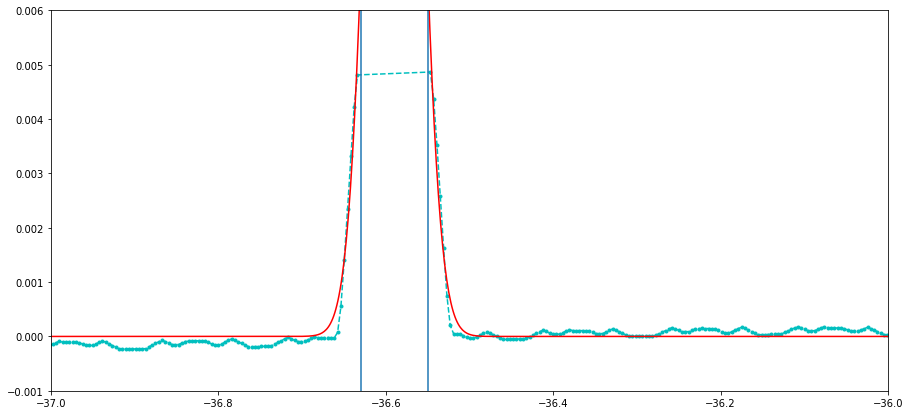

In [401]:
fita = np.linspace(-38,-33,4000)
fitb = gaussian_func(fita,  popt[0], popt[1],  popt[2])
plt.figure(figsize=(15,7))
plt.plot(a,b,'c.--')
plt.plot(fita,fitb,'r')
plt.xlim(-37,-36)
plt.axvline(-36.63)
plt.axvline(-36.55)
plt.ylim(-0.001,0.006)

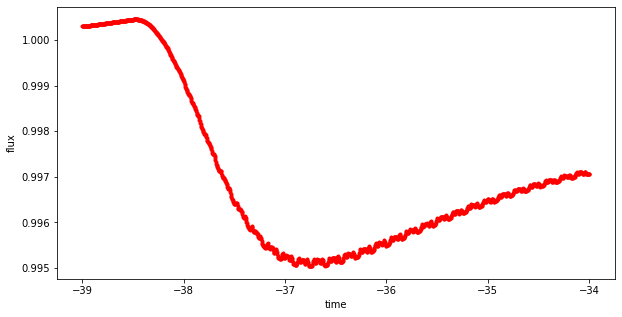

In [285]:
a, b = light_curve(basenpdir + '/modelU_140_90.0000_250.0000_noecli.linear',look=True)